In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [3]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [4]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [5]:
df = train_pos.append(train_neg).append(test_pos).append(test_neg)
df = df.sample(frac=1, random_state=911)

In [6]:
df

,0,0
12,>Negative 12,GT
34,>Positive 34,VVVPPFLQP
173,>Positive 173,GGGLG
49,>Positive 49,YYG
32,>Negative 32,GHKIATFQER
...,...,...
4,>Negative 4,IPQEVLP
8,>Negative 8,ALPMH
95,>Positive 95,VL
27,>Negative 27,HQIYP


In [7]:
def create_graph_data(str, label, enc):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

def preprocess(df):
    df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
    df.columns = ['bitter', 'seq']
    labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).tolist()
    seqs = df.seq.tolist()
    n = len(labels)
    descriptors = list(set([j for i in seqs for j in i]))
    enc = OneHotEncoder()
    X = np.array(descriptors).reshape((-1, 1))
    enc_arrays = enc.fit(X)

    protein_graphs = []
    for i in range(n):
        d = create_graph_data(seqs[i], labels[i], enc)
        protein_graphs.append(d)

    return(protein_graphs)

In [8]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = self.conv4(x, edge_index)
        x = x.relu()
        x = self.conv5(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (conv4): GCNConv(64, 64)
  (conv5): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [9]:
def train(model, optimizer, criterion):
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

    return(model)
    
def test(loader, model):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [10]:
# k Fold
nsplits = 10
graph_data = preprocess(df)
n=len(graph_data)

fold_train_acc = []
fold_test_acc = []

Fold 1:
Train size: 576, Test size: 64
Train Acc: 0.9253472222222222
Test Acc: 0.84375


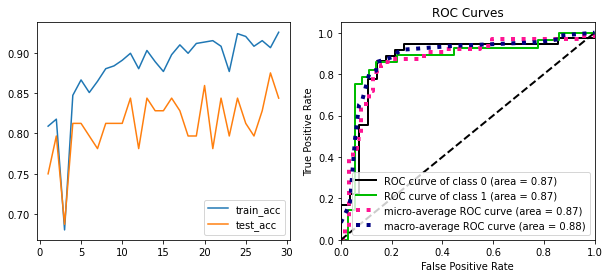

Fold 2:
Train size: 576, Test size: 64
Train Acc: 0.9322916666666666
Test Acc: 0.859375


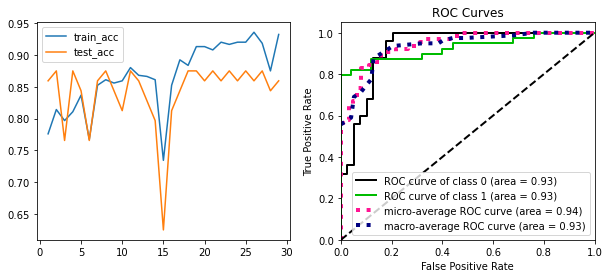

Fold 3:
Train size: 576, Test size: 64
Train Acc: 0.9270833333333334
Test Acc: 0.890625


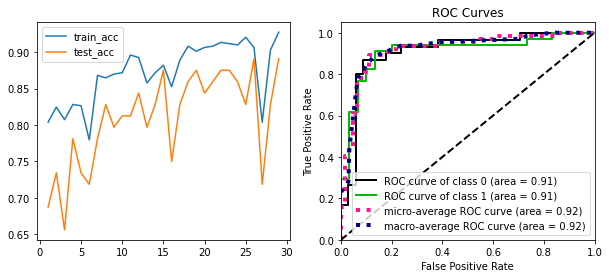

Fold 4:
Train size: 576, Test size: 64
Train Acc: 0.9409722222222222
Test Acc: 0.859375


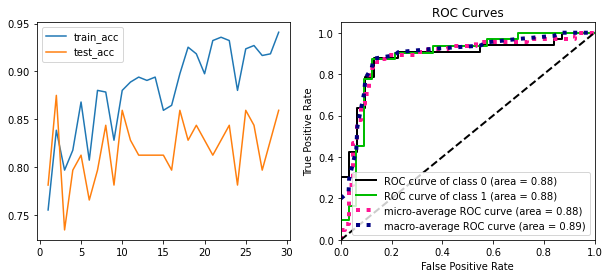

Fold 5:
Train size: 576, Test size: 64
Train Acc: 0.9322916666666666
Test Acc: 0.828125


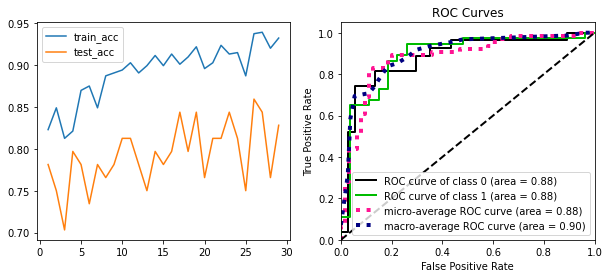

Fold 6:
Train size: 576, Test size: 64
Train Acc: 0.9392361111111112
Test Acc: 0.84375


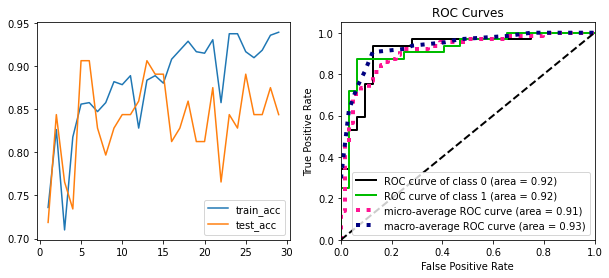

Fold 7:
Train size: 576, Test size: 64
Train Acc: 0.9409722222222222
Test Acc: 0.890625


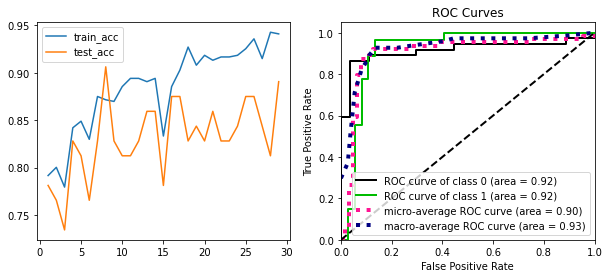

Fold 8:
Train size: 576, Test size: 64
Train Acc: 0.9236111111111112
Test Acc: 0.828125


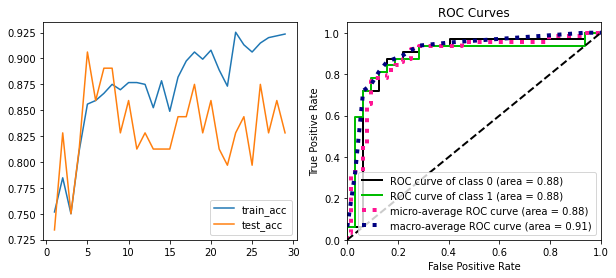

Fold 9:
Train size: 576, Test size: 64
Train Acc: 0.9496527777777778
Test Acc: 0.8125


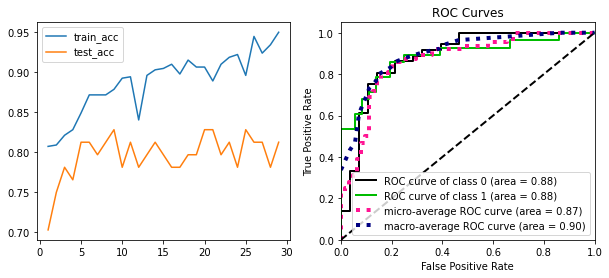

Fold 10:
Train size: 576, Test size: 64
Train Acc: 0.9097222222222222
Test Acc: 0.765625


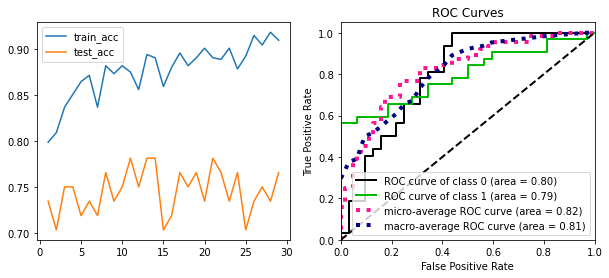

In [11]:
for i in range(nsplits):    
    test_indexes = list(range(int(n*(i)/nsplits), int(n*(i+1)/nsplits)))
    train_indexes = [i for i in range(n) if i not in test_indexes]

    test_data = [graph_data[i] for i in test_indexes]
    train_data = [graph_data[i] for i in train_indexes]

    train_loader = DataLoader(train_data, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle = True) 

    model = GCN(hidden_channels=16)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    criterion = torch.nn.CrossEntropyLoss()

    train_acc_list = []
    test_acc_list = []
    epochs_list = []

    for epoch in range(1, 30):
        model = train(model, optimizer, criterion)
        train_acc = test(train_loader, model)
        test_acc = test(test_loader, model)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        epochs_list.append(epoch)
        # print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
    
     
    print(f'Fold {i+1}:')
    print(f'Train size: {len(train_data)}, Test size: {len(test_data)}')
    print('Train Acc:', train_acc)
    print('Test Acc:', test_acc)
    
    fold_train_acc.append(train_acc)
    fold_test_acc.append(test_acc)

    fig, axs = plt.subplots(1,2, figsize=(10, 4))
    axs[0].plot(epochs_list, train_acc_list, label = 'train_acc')
    axs[0].plot(epochs_list, test_acc_list, label = 'test_acc')
    axs[0].legend()
    for data in test_loader:
        out = model(data.x, data.edge_index, data.batch)
        lab = data.y   
    skplt.metrics.plot_roc(lab, out.detach().numpy(), ax=axs[1])
    
    plt.show()

In [12]:
np.mean(fold_test_acc)

0.8421875